In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "deep-image-prior"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My drive/{}'.format(FOLDERNAME))

%cd drive/MyDrive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/MyDrive/deep-image-prior


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *
from models.unet import *

import torch
import torch.optim
import torchvision.transforms as transforms

from skimage.measure import compare_psnr
from models.downsampler import Downsampler

from utils.sr_utils import *

import pickle

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_type = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [3]:
train = torchvision.datasets.CIFAR10('data/Adversarial', download=True, train=True, transform=transforms.ToTensor())
val = torchvision.datasets.CIFAR10('data/Adversarial', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


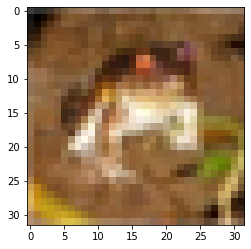

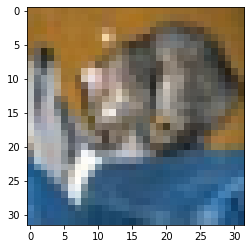

In [4]:
img1 = transforms.ToPILImage()(train[0][0])
plt.imshow(img1)
plt.show()
img2 = transforms.ToPILImage()(val[0][0])
plt.imshow(img2)
plt.show()

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=50)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=50)

In [6]:
l2_lambda = 0.0003

def closure(net_input, true_labels):
    out_labels = net.forward(net_input)

    total_loss = loss_type(out_labels, true_labels)
    l2_reg = torch.tensor(0.).to(device)
    for param in net.parameters():
        l2_reg += torch.norm(param)**2
    total_loss += l2_lambda * l2_reg

    total_loss.backward()
    
    return total_loss

def num_correct(pred_labels, true_labels):
    return (pred_labels==true_labels).sum()

def evaluate(data_loader):
    net.eval()
    total_correct, total_evaluated = 0, 0
    for data, labels in data_loader:
        pred_labels = net(data.to(device))
        nc = num_correct(pred_labels, labels.data.numpy())
        total_correct += nc
        total_evaluated += len(labels)
    return total_correct / total_evaluated

In [7]:
def optimize2(optimizer_type, parameters, closure, LR, num_epochs):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_epochs):
            net.train()
            epoch_loss = 0
            for data, labels in train_loader:
                optimizer.zero_grad()
                loss = closure(data.to(device), labels.to(device))
                optimizer.step()
                epoch_loss += loss
            print("Epoch %d: loss=%f; train_acc=%f; val_acc=%f"%(j+1, epoch_loss.detach(), evaluate(train_loader), evaluate(val_loader)))
    else:
        assert False

In [8]:
# net = UNetCIFAR()
# net.to(device)
# optimize2('adam', net.parameters(), closure, 1e-3, 100)

In [9]:
# pickle.dump(net, open("model_pickles/cifar10_unet_reg.pickle", "wb"))

In [10]:
net = pickle.load(open("model_pickles/cifar10_unet_reg.pickle", "rb"))

In [11]:
print(evaluate(train_loader), evaluate(val_loader))

0.93418 0.7078


In [12]:
def fgsm_batch(data, epsilon=0.01):
    data_perturbed = data + torch.sign(data.grad)*epsilon
    return data_perturbed

def noisy_batch(data, epsilon=0.01):
    noise = torch.randn_like(data)*epsilon
    return data + noise

Accuracy: clean=70.7800%; noisy=70.2600%; perturbed=5.9100%


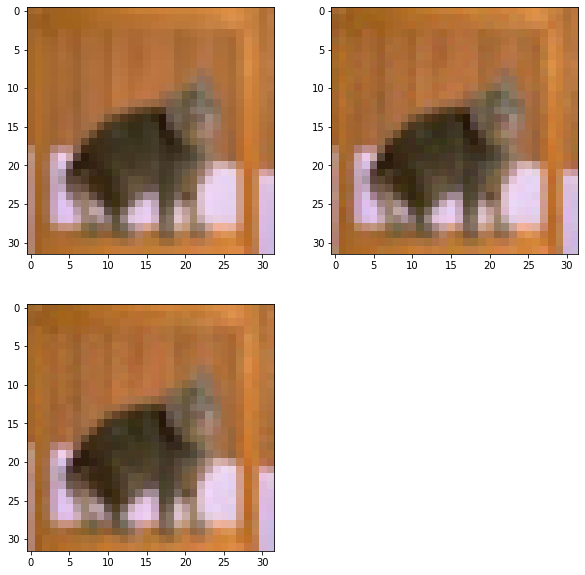

In [13]:
net.eval()
nc_clean = 0
nc_noisy = 0
nc_perturbed = 0
epsilon = 0.01
for data, labels in val_loader:
    data, labels = data.to(device), labels.to(device)

    pred_labels = net(data)
    nc_clean += num_correct(pred_labels, labels.data.cpu().numpy())

    data_noisy = noisy_batch(data, epsilon=epsilon)
    pred_labels = net(data_noisy)
    nc_noisy += num_correct(pred_labels, labels.data.cpu().numpy())

    data.requires_grad = True

    loss_val = closure(data, labels)

    data_perturbed = fgsm_batch(data, epsilon=epsilon)

    pred_labels = net(data_perturbed)
    nc_perturbed += num_correct(pred_labels, labels.data.cpu().numpy())

n = len(val)
print("Accuracy: clean=%.4f%%; noisy=%.4f%%; perturbed=%.4f%%"%(nc_clean/n*100, nc_noisy/n*100, nc_perturbed/n*100))
img1 = transforms.ToPILImage()(data[0])
img2 = transforms.ToPILImage()(data_noisy[0])
img3 = transforms.ToPILImage()(data_perturbed[0])

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax1.imshow(img1)
ax2 = fig.add_subplot(222)
ax2.imshow(img2)
ax3 = fig.add_subplot(223)
ax3.imshow(img3)
plt.show()